# 1. K-Nearest Neighbors
References:
https://pythonspot.com/k-nearest-neighbors/
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab3-py.html

## 1) IRIS Example

In [1]:
# Import libraries
import warnings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings(action='ignore')

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', 'Green','Blue'])
h = .02

1. Load Iris data.

In [2]:
# import some data to play with
iris = datasets.load_iris()

# prepare data (X, y)
X = iris.data[:, :2]
y = iris.target

2. Do KNN classifier.

In [3]:
# Set the number of neighbors.
n_neighbors = 6
# we create an instance of Neighbours Classifier and fit the data.
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=6)

3. Produce a confusion matrix in order to determine how many observations were correctly or incorrectly classified.

In [4]:
pred= knn.predict(X)
print(confusion_matrix(y, pred).T)
print(classification_report(y, pred, digits=3))

[[49  0  0]
 [ 1 43 17]
 [ 0  7 33]]
              precision    recall  f1-score   support

           0      1.000     0.980     0.990        50
           1      0.705     0.860     0.775        50
           2      0.825     0.660     0.733        50

    accuracy                          0.833       150
   macro avg      0.843     0.833     0.833       150
weighted avg      0.843     0.833     0.833       150



4. Let's visualize the classification result!

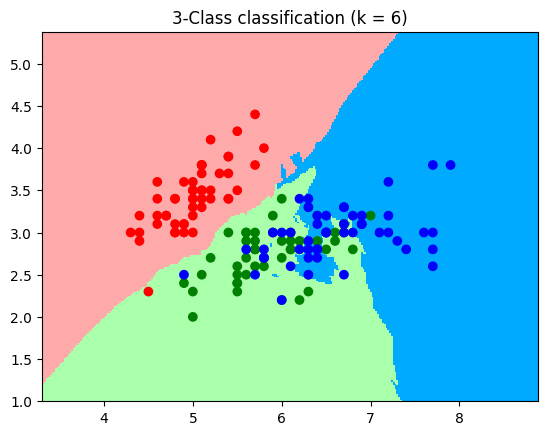

In [5]:
# calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

## 2) Smarket data from ISLR. Do it yourself.
This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005.
For each date, we have recorded the percentage returns for each of the five previous trading days (Lag1 through Lag5).

Do KNN classification yourself and find the best fit.

In [6]:
# Load data
import pandas as pd
df = pd.read_csv('./data/Smarket.csv', index_col=0, parse_dates = True)
df.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_code
Year,,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


1. Split data into X_train, y_train, X_test, y_test
- Target (Y): Direction_code
- Feature (X): Lag1, Lag2
- Training data: Year 2001 ~ 2004
- Test data; Year 2005

In [7]:
# Split data for training and testing
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

2.  Create KNN classifier and fit the model.

In [8]:
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

3. Test your model with Test data, and determine how many observations were correctly or incorrectly classified.

In [9]:
# predict your model with test data
pred= knn.predict(X_test)
# See the rsult of confusion matrix & classification report
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[63 79]
 [48 62]]
              precision    recall  f1-score   support

        Down      0.444     0.568     0.498       111
          Up      0.564     0.440     0.494       141

    accuracy                          0.496       252
   macro avg      0.504     0.504     0.496       252
weighted avg      0.511     0.496     0.496       252



# 2. Gaussian Mixture Model

## 1) Expectation-Maximization (EM)
References: https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php

## 1-1) Implementation of EM

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import norm

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(0)

In [11]:
X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+15 # Create data cluster 1
X1 = X*np.random.rand(len(X))-15 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above

In [12]:
class GM1D:
    def __init__(self,X,iterations):
        self.iterations = iterations
        self.X = X
        self.mu = None
        self.pi = None
        self.var = None

    def run(self):

        """
        Instantiate the random mu, pi and var
        """
        self.mu = [-8,8,5]
        self.pi = [1/3,1/3,1/3]
        self.var = [5,3,1]


        """
        E-Step
        """

        for iter in range(self.iterations):

            """Create the array r with dimensionality nxK"""
            r = np.zeros((len(self.X),3))

            """
            Probability for each datapoint x_i to belong to gaussian g
            """
            for c,g,p in zip(range(3),[norm(loc=self.mu[0],scale=self.var[0]),
                                       norm(loc=self.mu[1],scale=self.var[1]),
                                       norm(loc=self.mu[2],scale=self.var[2])],self.pi):
                ####################################################################
                """ 1. Calculate the probability 𝑝(𝑥_𝑚;mu)*tau """
                r[:,c] = p*g.pdf(self.X)
                ####################################################################


            ################################################################################
            """
            2. Calculate 𝑇_(𝑘,𝑚)^𝑡 : Normalize the probabilities such that each row of r sums to 1.
            """
            for i in range(len(r)):
                r[i] = r[i]/(np.sum(self.pi)*np.sum(r,axis=1)[i])
            ################################################################################



            """Plot the data"""

            fig = plt.figure(figsize=(10,10))
            ax0 = fig.add_subplot(111)


            for i in range(len(r)):
                ax0.scatter(self.X[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]).reshape(1,-1),s=100)


            """Plot the gaussians"""
            for g,c in zip([norm(loc=self.mu[0],scale=self.var[0]).pdf(np.linspace(-20,20,num=60)),
                            norm(loc=self.mu[1],scale=self.var[1]).pdf(np.linspace(-20,20,num=60)),
                            norm(loc=self.mu[2],scale=self.var[2]).pdf(np.linspace(-20,20,num=60))],['r','g','b']):
                ax0.plot(np.linspace(-20,20,num=60),g,c=c)


            """M-Step"""

            ################################################################################
            """  3. calculate ∑_𝑚 𝑇_(𝑘,𝑚)^𝑡 """
            m_c = []  # cx1
            for c in range(len(r[0])):
                m = np.sum(r[:,c])
                m_c.append(m) # For each cluster c, calculate the m_c and add it to the list m_c
            ################################################################################


            ################################################################################
            """4. calculate 𝜏_𝑘^(𝑡+1)"""
            for k in range(len(m_c)):
                self.pi[k] = (m_c[k]/np.sum(m_c)) # For each cluster c, calculate the fraction of points pi_c which belongs to cluster c
            ################################################################################


            ################################################################################
            """calculate mu_k"""
            self.mu = np.sum(self.X.reshape(len(self.X),1)*r,axis=0)/m_c
            ################################################################################


            """calculate var_c"""
            var_c = []

            for c in range(len(r[0])):
                var_c.append((1/m_c[c])*np.dot(((np.array(r[:,c]).reshape(60,1))*(self.X.reshape(len(self.X),1)-self.mu[c])).T,(self.X.reshape(len(self.X),1)-self.mu[c])))

            plt.show()

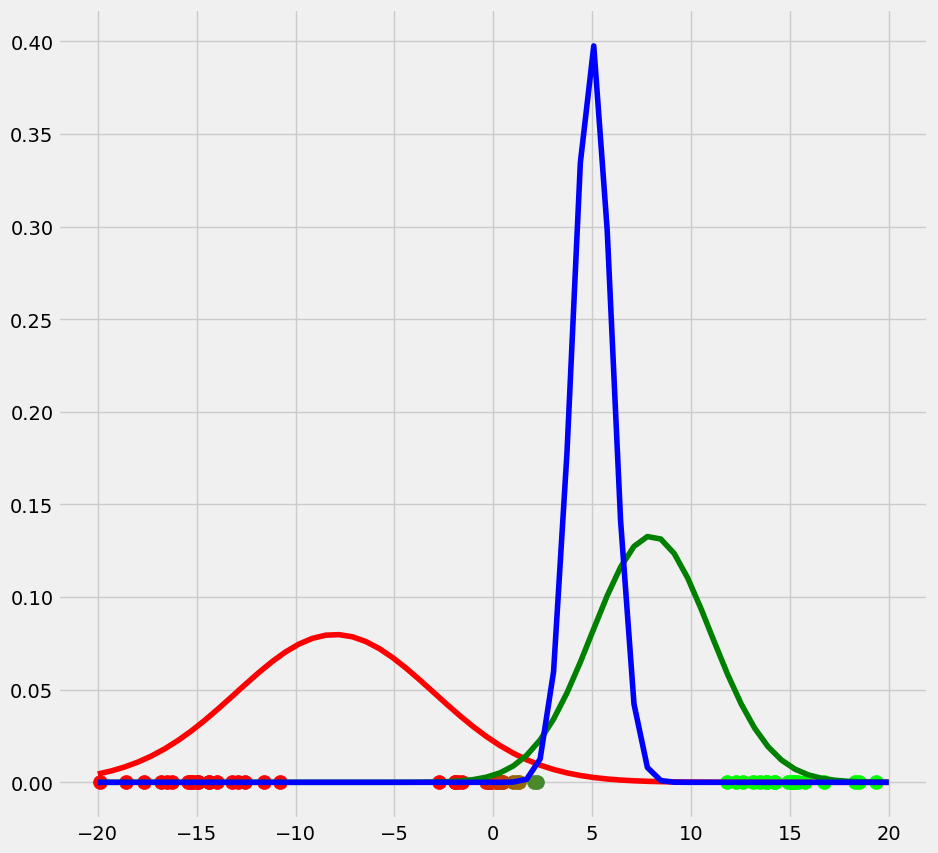

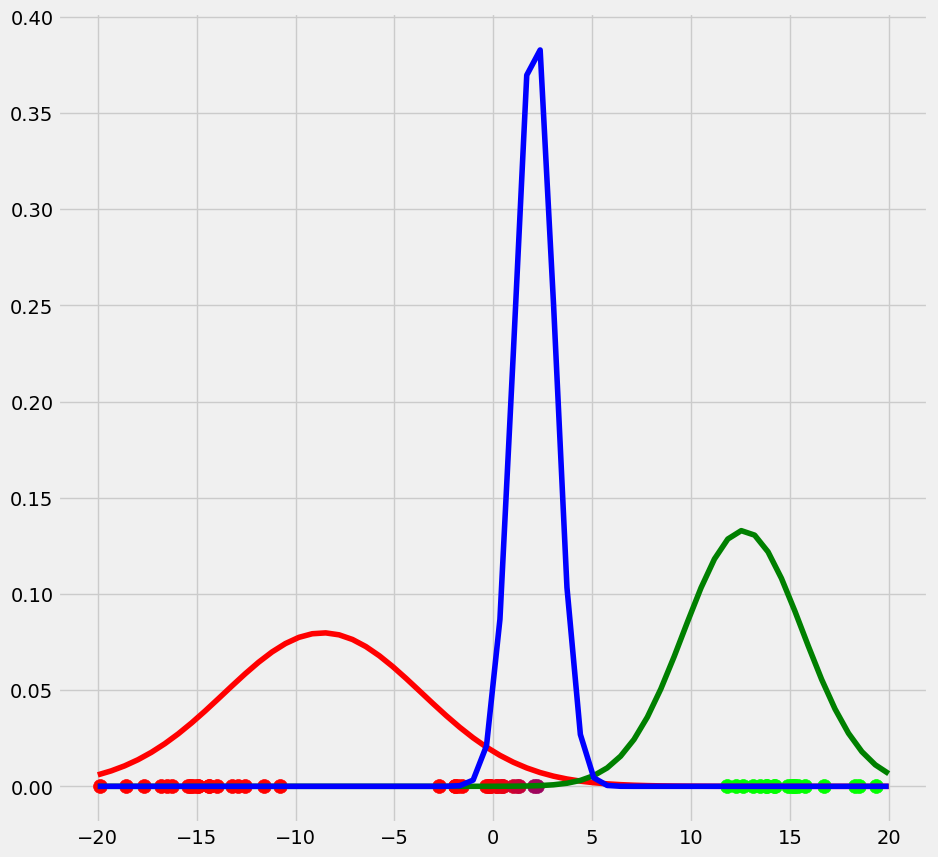

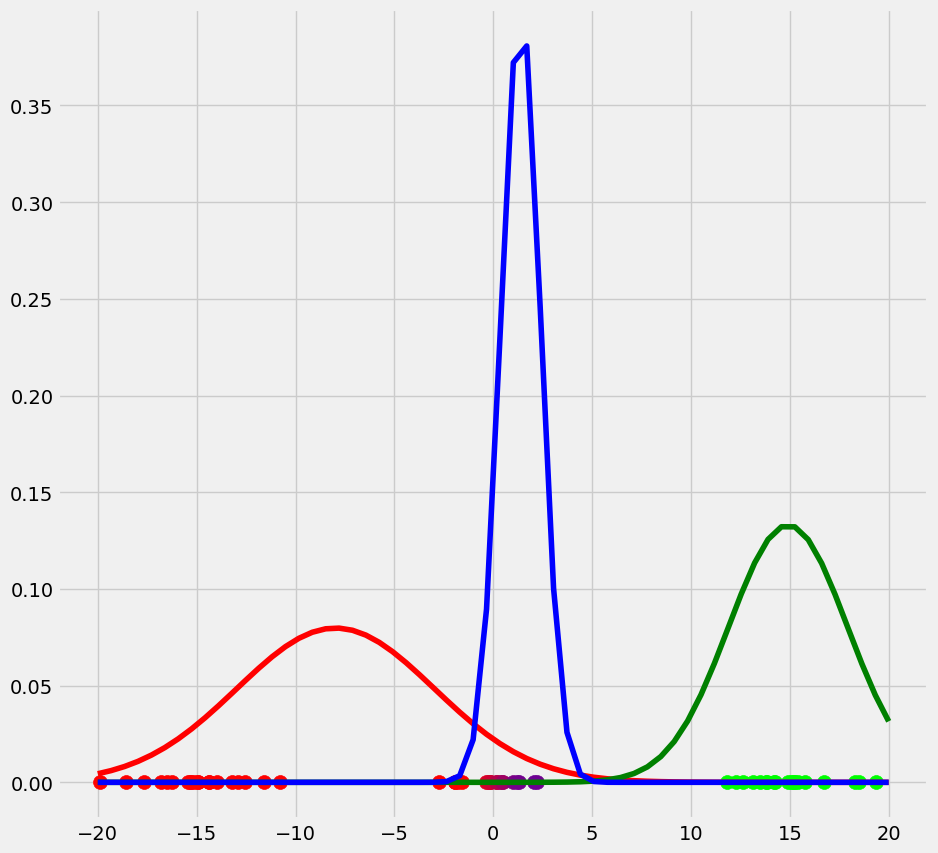

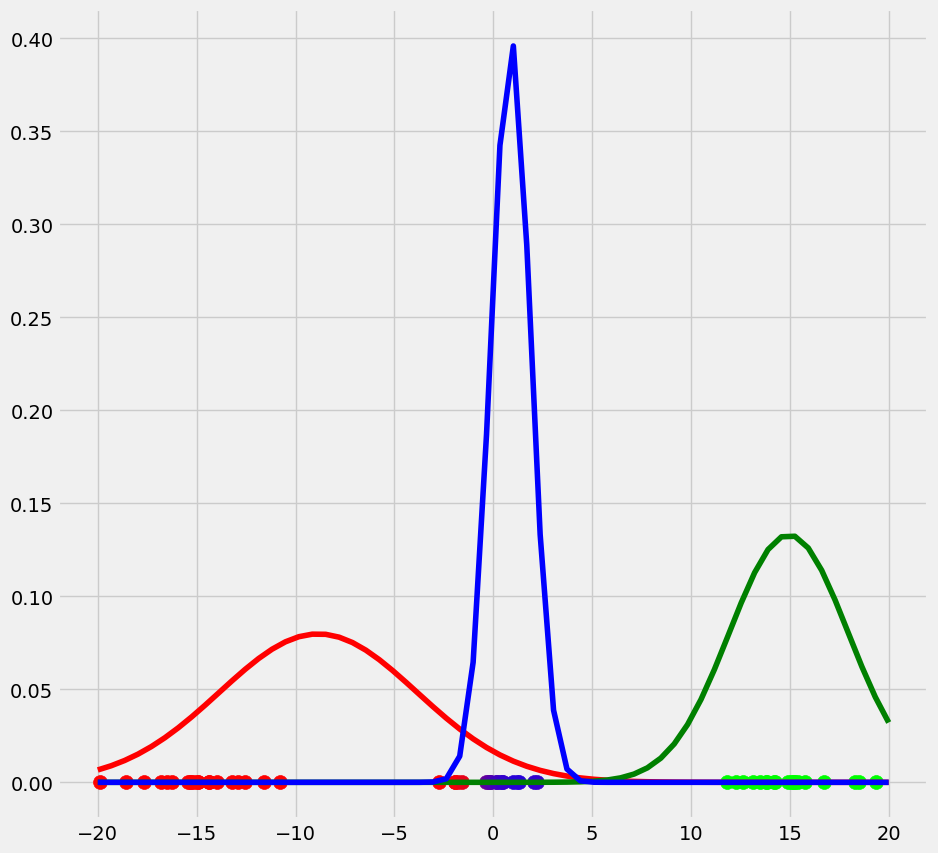

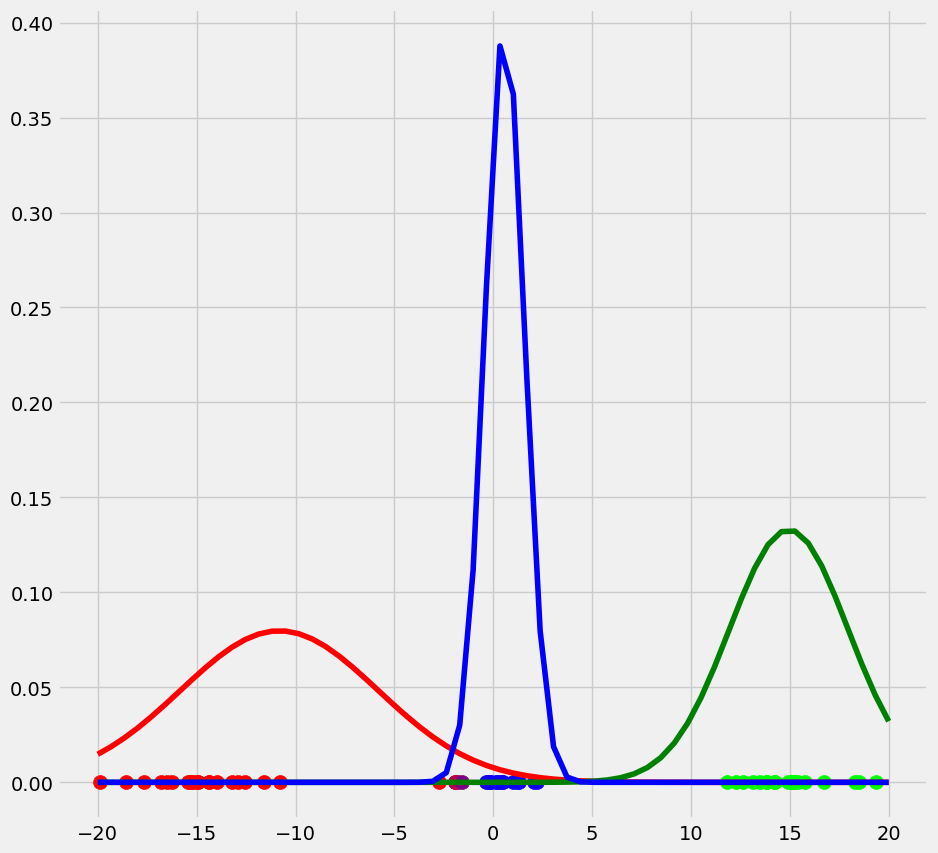

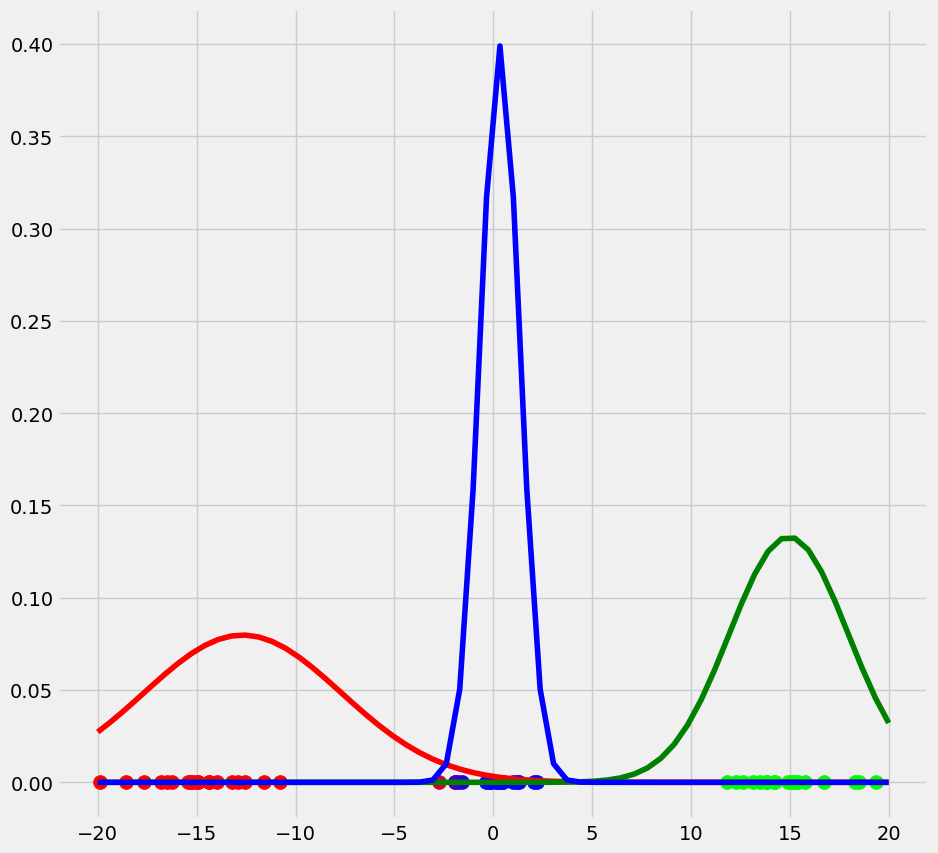

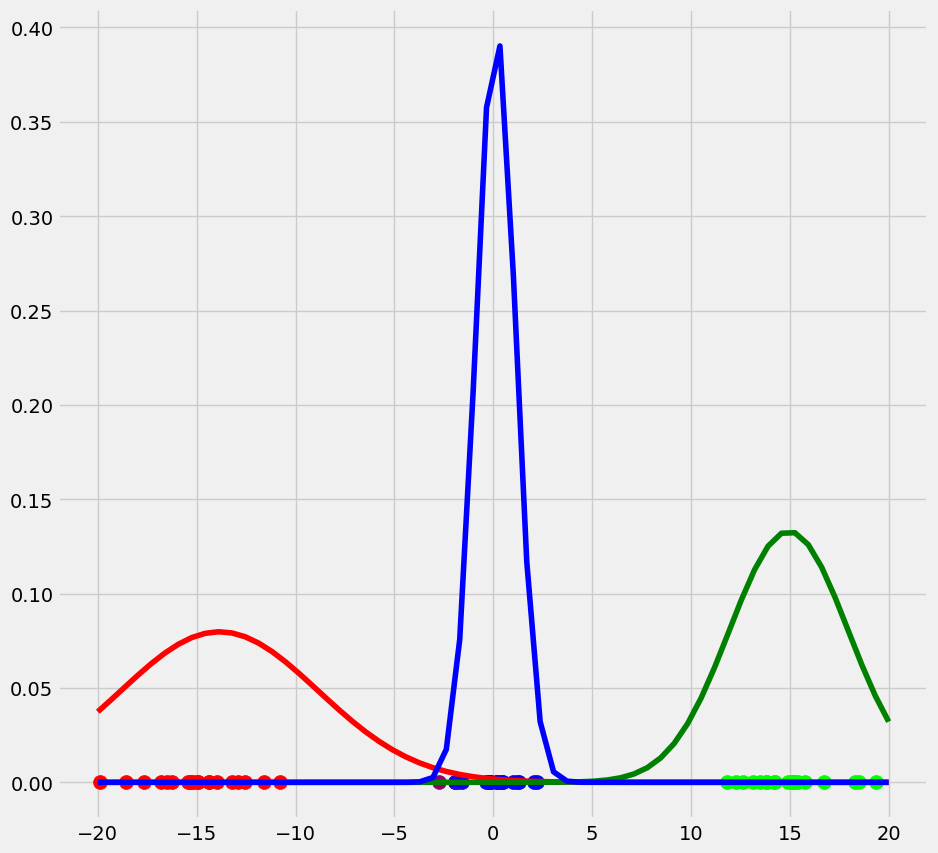

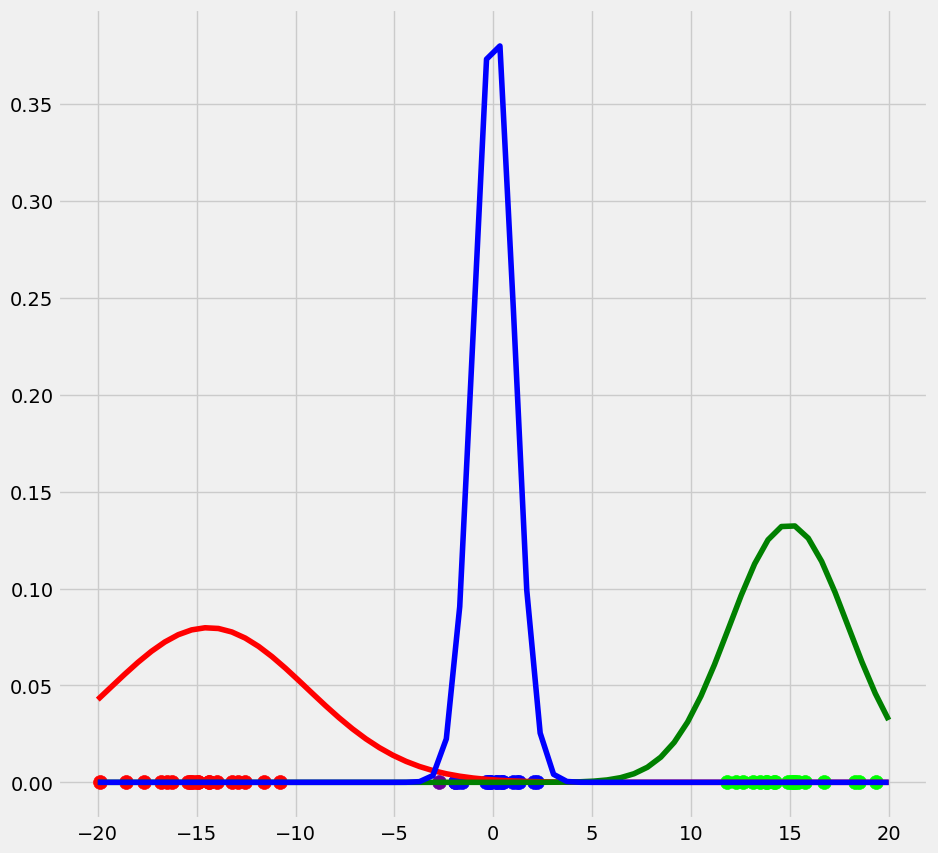

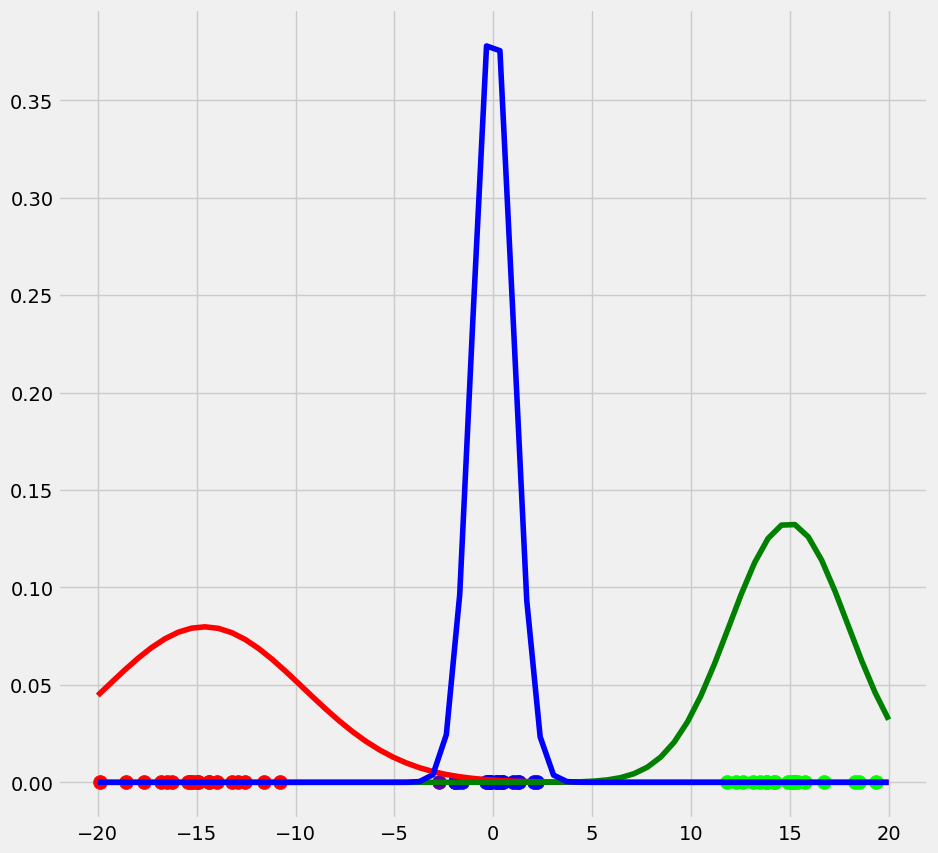

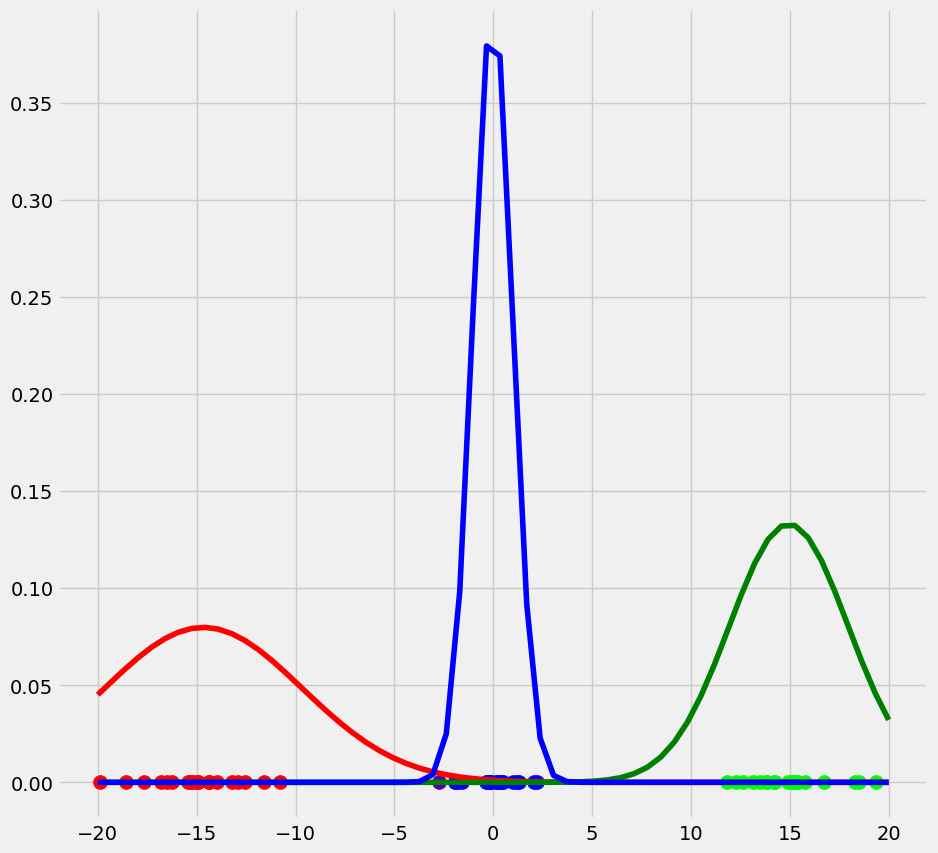

In [13]:
# Run the GM1D
GM1D = GM1D(X_tot,10)
GM1D.run()

## 1-2) EM using SKlearn package

In [14]:
from sklearn import mixture
# Fit a Gaussian mixture with EM using five components
X = X_tot.reshape(-1, 1)
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X)

print(gmm.means_)
print(gmm.covariances_)

[[ 14.94508323]
 [-15.02626455]
 [ -0.08220307]]
[[[3.94633317]]

 [[4.80831773]]

 [[1.76060159]]]


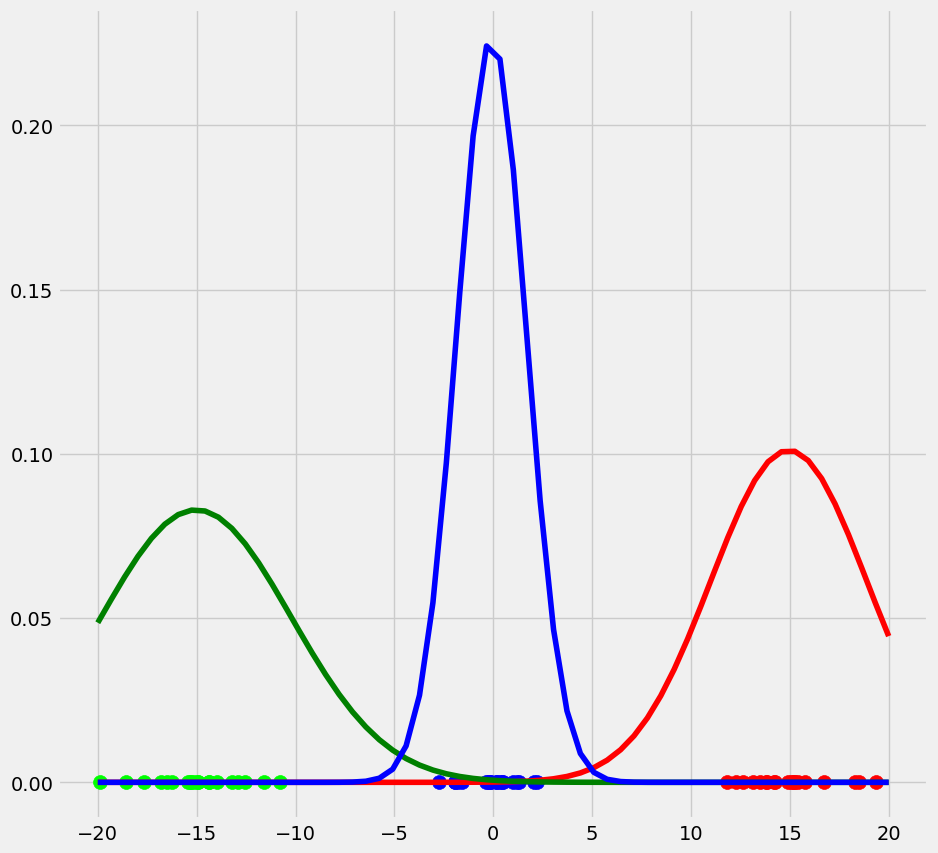

In [15]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
r = gmm.predict_proba(X)

for i in range(len(r)):
    ax0.scatter(X[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]).reshape(1,-1),s=100)


"""Plot the gaussians"""
for g,c in zip([norm(loc=gmm.means_[0],scale=gmm.covariances_[0][0]).pdf(np.linspace(-20,20,num=60)),
                norm(loc=gmm.means_[1],scale=gmm.covariances_[1][0]).pdf(np.linspace(-20,20,num=60)),
                norm(loc=gmm.means_[2],scale=gmm.covariances_[2][0]).pdf(np.linspace(-20,20,num=60))],['r','g','b']):
    ax0.plot(np.linspace(-20,20,num=60),g,c=c)

## 2) Markov Chain Monte Carlo (MH algorithm)
Reference: http://people.duke.edu/~ccc14/sta-663/MCMC.html

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [17]:
n = 100
h = 61
p = h/n
a, b = 10, 10
thetas = np.linspace(0, 1, 200)
prior = st.beta(a, b)
P = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)

In [18]:
def target_P(theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return st.binom(100, theta).pmf(61)*st.beta(10, 10).pdf(theta)

def proposal_P(theta_mu, theta_x):
    return st.norm(theta_mu, sigma).pdf(theta_x)

sigma = 0.3

##  Metropolis Hastings
# Initialization
naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
post = st.beta(h+a, n-h+b)
nmcmc = len(samples)//2

for i in range(niters):
    # Proposal
    theta_p = theta + st.norm(0, sigma).rvs()

    ################################################################################
    """ 1. Use target_P, proposal_P function to calculate The acceptance probability """
    rho = min(1, (target_P(theta_p)*proposal_P(theta, theta_p))/(target_P(theta))*proposal_P(theta_p, theta))
    ################################################################################

    ################################################################################
    """ 2. Sample u ~ Uniform, and then use u to complete the algorithm. """
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    ################################################################################

    samples[i+1] = theta
nmcmc = len(samples)//2

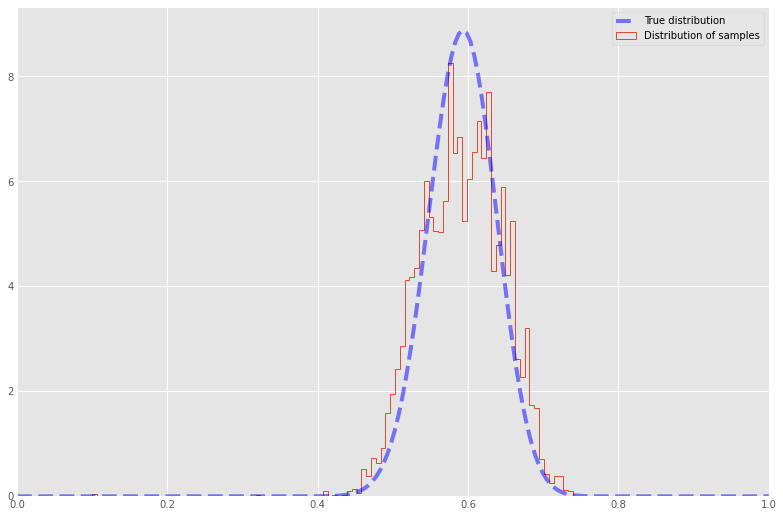

In [ ]:
# Plot the results
post = st.beta(h+a, n-h+b)
plt.figure(figsize=(12, 9))
plt.hist(samples, 100, histtype='step',density=True, linewidth=1, label='Distribution of samples');
plt.plot(thetas, post.pdf(thetas), c='blue', linestyle='--', alpha=0.5, label='True distribution')
plt.xlim([0,1]);
plt.legend(loc='best');